Questo notebook segue le indicazioni di https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!unzip "/content/drive/My Drive/Colab Notebooks/kagglecatsanddogs_5340.zip" -d "/content/images"

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/images/PetImages/Dog/5500.jpg  
  inflating: /content/images/PetImages/Dog/5501.jpg  
  inflating: /content/images/PetImages/Dog/5502.jpg  
  inflating: /content/images/PetImages/Dog/5503.jpg  
  inflating: /content/images/PetImages/Dog/5504.jpg  
  inflating: /content/images/PetImages/Dog/5505.jpg  
  inflating: /content/images/PetImages/Dog/5506.jpg  
  inflating: /content/images/PetImages/Dog/5507.jpg  
  inflating: /content/images/PetImages/Dog/5508.jpg  
  inflating: /content/images/PetImages/Dog/5509.jpg  
  inflating: /content/images/PetImages/Dog/551.jpg  
  inflating: /content/images/PetImages/Dog/5510.jpg  
  inflating: /content/images/PetImages/Dog/5511.jpg  
  inflating: /content/images/PetImages/Dog/5512.jpg  
  inflating: /content/images/PetImages/Dog/5513.jpg  
  inflating: /content/images/PetImages/Dog/5514.jpg  
  inflating: /content/images/PetImages/Dog/5515.jpg  
  inflating: /content/images/PetI

Plot and look at some photos


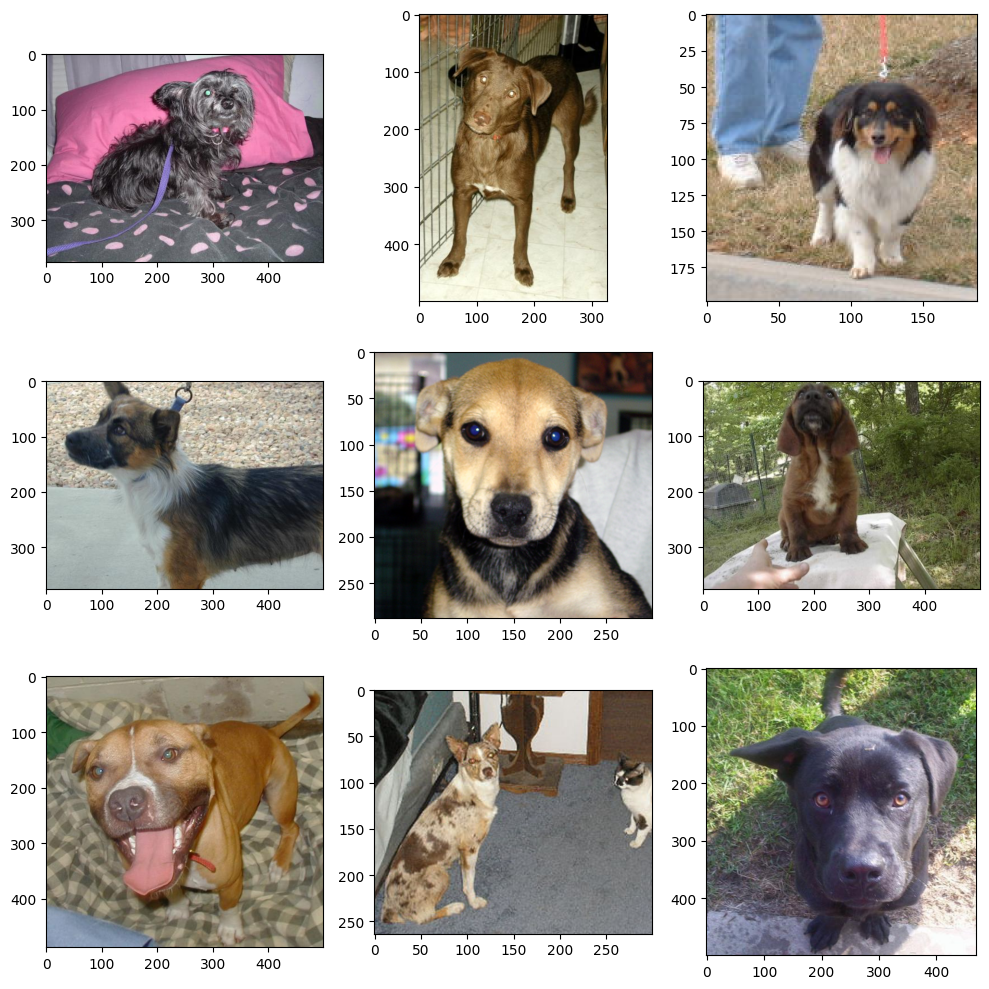

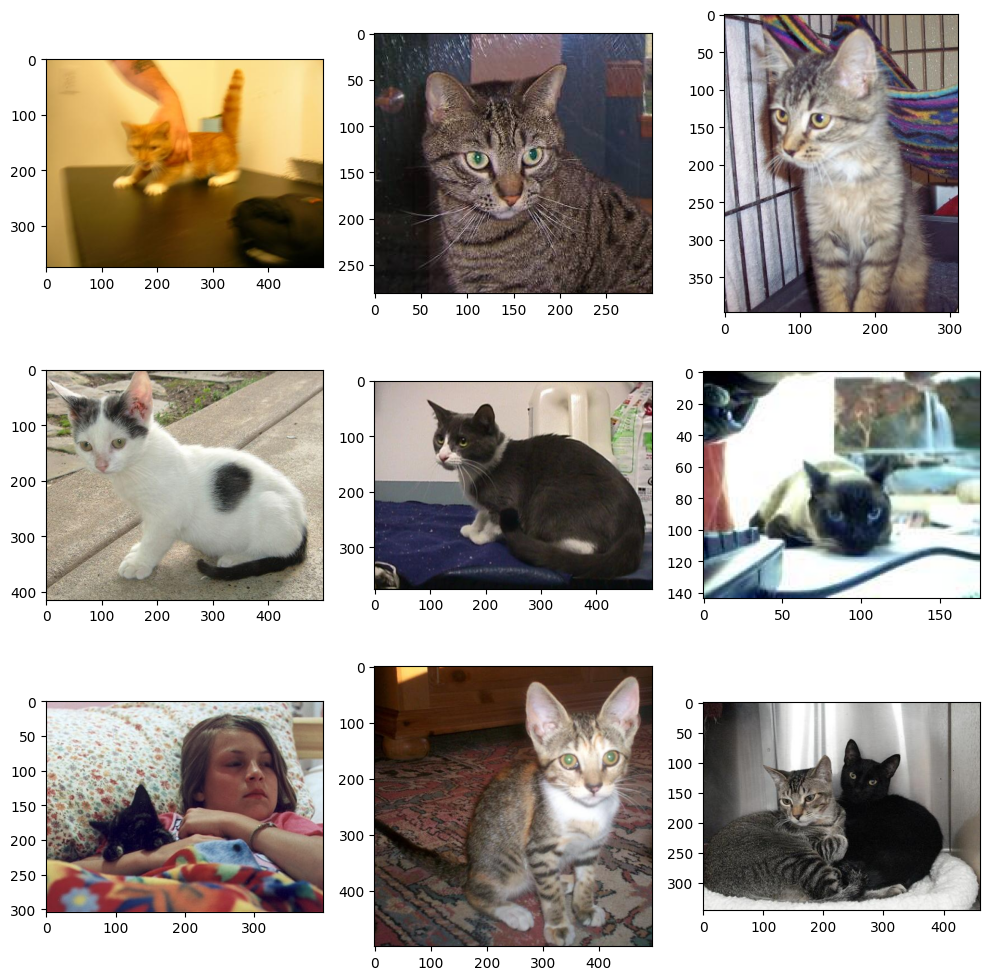

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

def plot_images(folder, category, num_images=9):
    # Crea una griglia di subplot per le immagini
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    axes = axes.flatten()  # Trasforma la griglia in un array lineare per un facile accesso

    for i in range(num_images):
        # Definisce il nome del file
        filename = f'{folder}/{category}/{i}.jpg'
        try:
            # define subplot
            plt.subplot(330 + 1 + i)
            # load image pixels
            image = imread(filename)
            # plot raw pixel data
            plt.imshow(image)
        except FileNotFoundError:
            print(f"File {filename} not found.")
            axes[i].set_visible(False)  # Nasconde subplot se l'immagine non è trovata

    plt.tight_layout()
    plt.show()

# Percorso della cartella del dataset
folder = '/content/images/PetImages'

# Mostra le prime immagini di cani e gatti
plot_images(folder, 'Dog')
plot_images(folder, 'Cat')


Cerchiamo immagini corrotte


In [10]:
from PIL import Image
import os

def check_images(s_dir, ext_list):
    bad_images = []
    bad_ext = []
    for folder in os.listdir(s_dir):
        folder_path = os.path.join(s_dir, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                img = Image.open(file_path)  # Tentativo di aprire l'immagine
                img.verify()  # Verifica che sia un'immagine
                img.close()  # Chiudi l'immagine
                if file.split('.')[-1].lower() not in ext_list:
                    bad_ext.append(file_path)
            except (IOError, SyntaxError) as e:
                bad_images.append(file_path)
    return bad_images, bad_ext

s_dir = '/content/images/PetImages'
ext_list = ['jpg', 'jpeg', 'png']  # Estensioni di file accettate
bad_images, bad_ext = check_images(s_dir, ext_list)

print(f"Immagini corrotte: {bad_images}")
print(f"File con estensioni errate: {bad_ext}")



Immagini corrotte: ['/content/images/PetImages/Cat/Thumbs.db', '/content/images/PetImages/Cat/666.jpg', '/content/images/PetImages/Dog/Thumbs.db', '/content/images/PetImages/Dog/11702.jpg']
File con estensioni errate: []


Eliminiamo le immagini corrotte

In [11]:
for image in bad_images:
  os.remove(image)
for image in bad_ext:
  os.remove(image)


Separiamo in set di train e test e ridimensioniamo le immagini. Lo split è fatto tenendo 80% immagini per il training e 20% per il testing.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creazione di generatori per il training e la validazione
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/images/PetImages/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    '/content/images/PetImages/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


Sviluppiamo un modello CNN a tre blocchi


In [12]:
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import keras

# Funzione con definizione del modello
def define_model():
    model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid perché è una classificazione binaria
    ])
    model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=0.001),
              metrics=['accuracy', Precision(), Recall()])
    return model

In [13]:

# Funzione che calcola F1-score
def calculate_f1_score(precision, recall):
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

# Funzione per fare i grafici
def summarize_diagnostics(history):
    num_metrics = len(history.history.keys()) // 2 - 1
    # Configura la dimensione del subplot in base al numero di metriche
    pyplot.figure(figsize=(10, 6 * num_metrics))
    # Plot della loss
    pyplot.subplot(num_metrics + 1, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='validation')
    pyplot.legend()

    metric_names = ['accuracy', 'precision', 'recall']

    for i, metric in enumerate(metric_names, start=2):
        if f'{metric}' in history.history:
            pyplot.subplot(num_metrics + 1, 1, i)
            pyplot.title(f'{metric.capitalize()}')
            pyplot.plot(history.history[metric], color='blue', label='train')
            if f'val_{metric}' in history.history:
                pyplot.plot(history.history[f'val_{metric}'], color='orange', label='validation')
            pyplot.legend()
    # Ottimizza lo spazio tra i plot
    pyplot.tight_layout()


def run_test_harness():
    # definiamo il modello
    model = define_model()
    # allenamento modello
    history = model.fit(train_generator, steps_per_epoch=len(train_generator),
        validation_data=validation_generator, validation_steps=len(validation_generator), epochs=20, verbose=1)
    # valutazione modello
    results = model.evaluate(validation_generator, steps=len(validation_generator), verbose=1)
    print('> Accuracy: %.3f' % (results[1] * 100.0))
    print('> Precision: %.3f' % (results[2]))
    print('> Recall: %.3f' % (results[3]))
    # Calcola l'F1-score
    f1_score = calculate_f1_score(results[2], results[3])
    print('> F1-score: %.3f' % (f1_score))
    # Plotta le curve
    summarize_diagnostics(history)
    return(model, history)

Epoch 1/20
 33/625 [>.............................] - ETA: 1:02 - loss: 0.9360 - accuracy: 0.4934 - precision: 0.4880 - recall: 0.5451

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 100s 146ms/step - loss: 0.5924 - accuracy: 0.6844 - precision: 0.6838 - recall: 0.6861 - val_loss: 0.5133 - val_accuracy: 0.7405 - val_precision: 0.8026 - val_recall: 0.6379
Epoch 2/20
625/625 [==============================] - 61s 98ms/step - loss: 0.4569 - accuracy: 0.7833 - precision: 0.7904 - recall: 0.7711 - val_loss: 0.4529 - val_accuracy: 0.7877 - val_precision: 0.8421 - val_recall: 0.7083
Epoch 3/20
625/625 [==============================] - 65s 104ms/step - loss: 0.3915 - accuracy: 0.8229 - precision: 0.8270 - recall: 0.8166 - val_loss: 0.4112 - val_accuracy: 0.8129 - val_precision: 0.8266 - val_recall: 0.7919
Epoch 4/20
625/625 [==============================] - 62s 99ms/step - loss: 0.3189 - accuracy: 0.8627 - precision: 0.8641 - recall: 0.8609 - val_loss: 0.4522 - val_accuracy: 0.8025 - val_precision: 0.7698 - val_recall: 0.8631
Epoch 5/20
625/625 [==============================] - 62s 100ms/step - loss: 0.2431 - accuracy: 0.9000 -

AttributeError: 'History' object has no attribute 'keys'

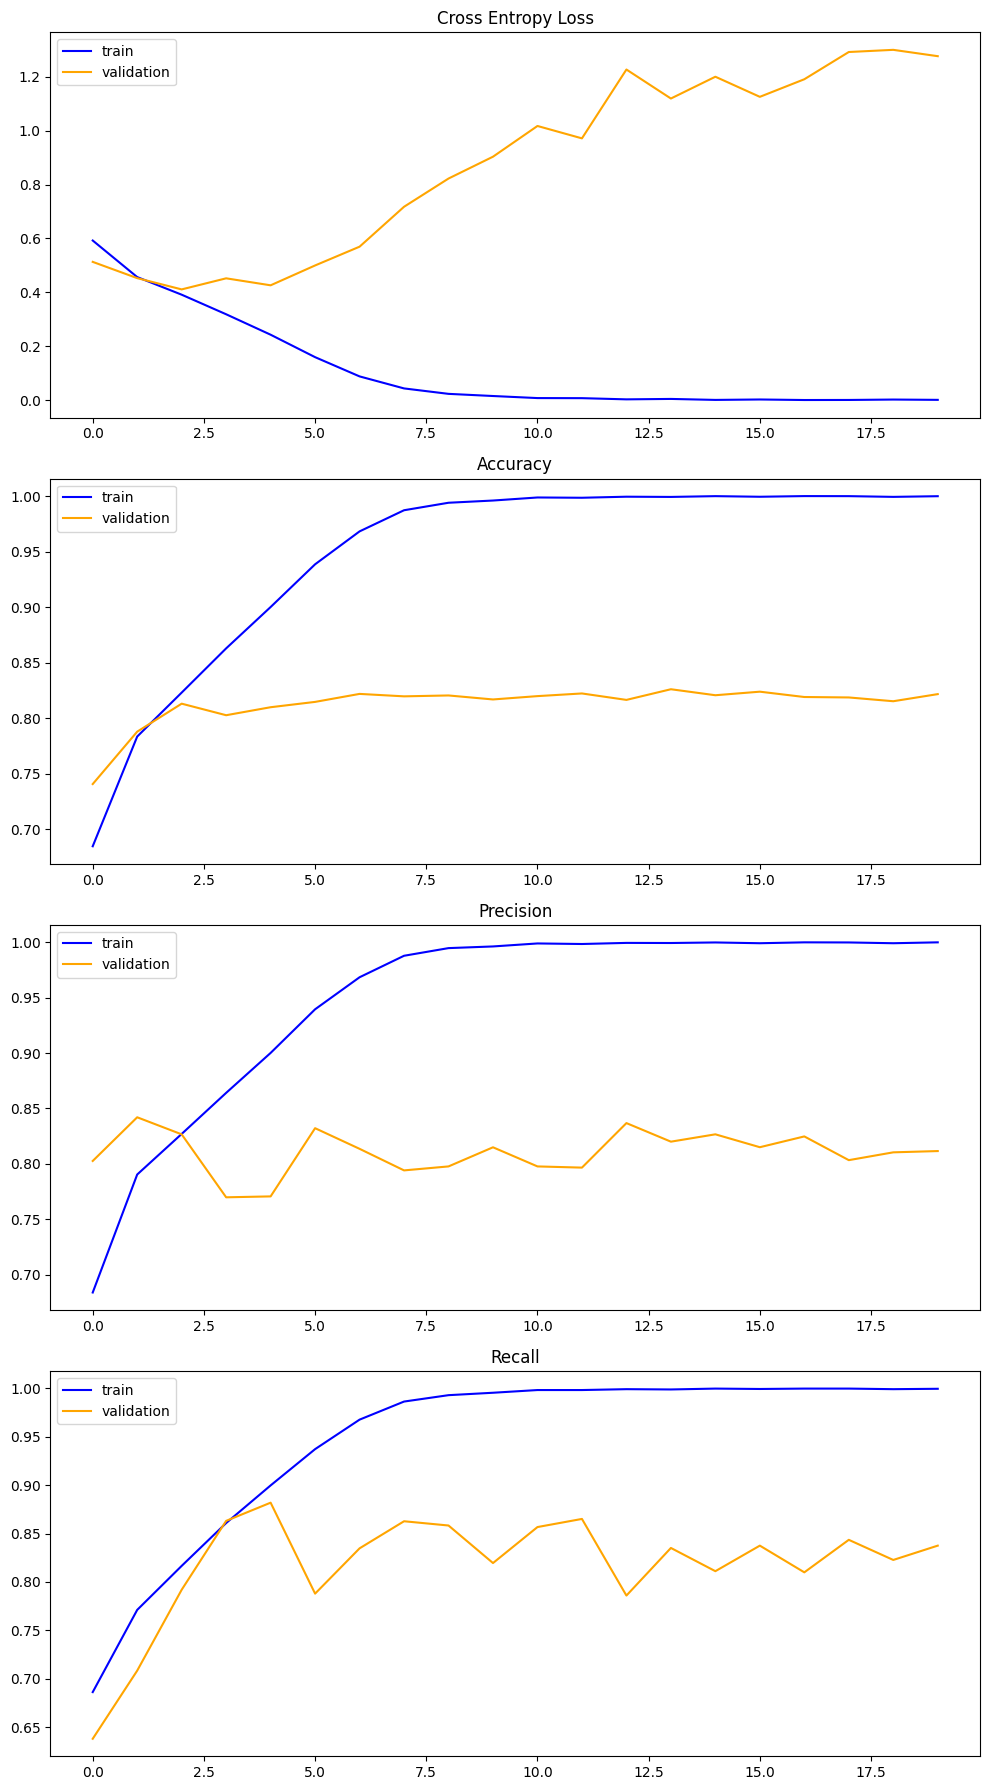

In [ ]:
H_simple_1, history_simple_1=run_test_harness()
summarize_diagnostics(H_simple_1)

Dropout Regularization

In [ ]:
#aggiungiamo il dropout nella definizione del modello

def define_model():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Dropout
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Dropout
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Dropout
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),  # Aumenta il Dropout prima dello strato denso finale
    Dense(1, activation='sigmoid')
    ])
	 #proviamo SGD come ottimizzatore
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model



Epoch 1/20
625/625 [==============================] - 71s 112ms/step - loss: 0.6905 - accuracy: 0.5282 - precision_2: 0.5315 - recall_2: 0.4744 - val_loss: 0.6936 - val_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 1.0000
Epoch 2/20
625/625 [==============================] - 71s 113ms/step - loss: 0.6933 - accuracy: 0.5027 - precision_2: 0.5029 - recall_2: 0.4817 - val_loss: 0.6911 - val_accuracy: 0.5160 - val_precision_2: 0.8704 - val_recall_2: 0.0376
Epoch 3/20
625/625 [==============================] - 69s 110ms/step - loss: 0.6919 - accuracy: 0.5142 - precision_2: 0.5157 - recall_2: 0.4672 - val_loss: 0.6957 - val_accuracy: 0.5000 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/20
625/625 [==============================] - 69s 110ms/step - loss: 0.6938 - accuracy: 0.4924 - precision_2: 0.4922 - recall_2: 0.4804 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/20
625/625 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


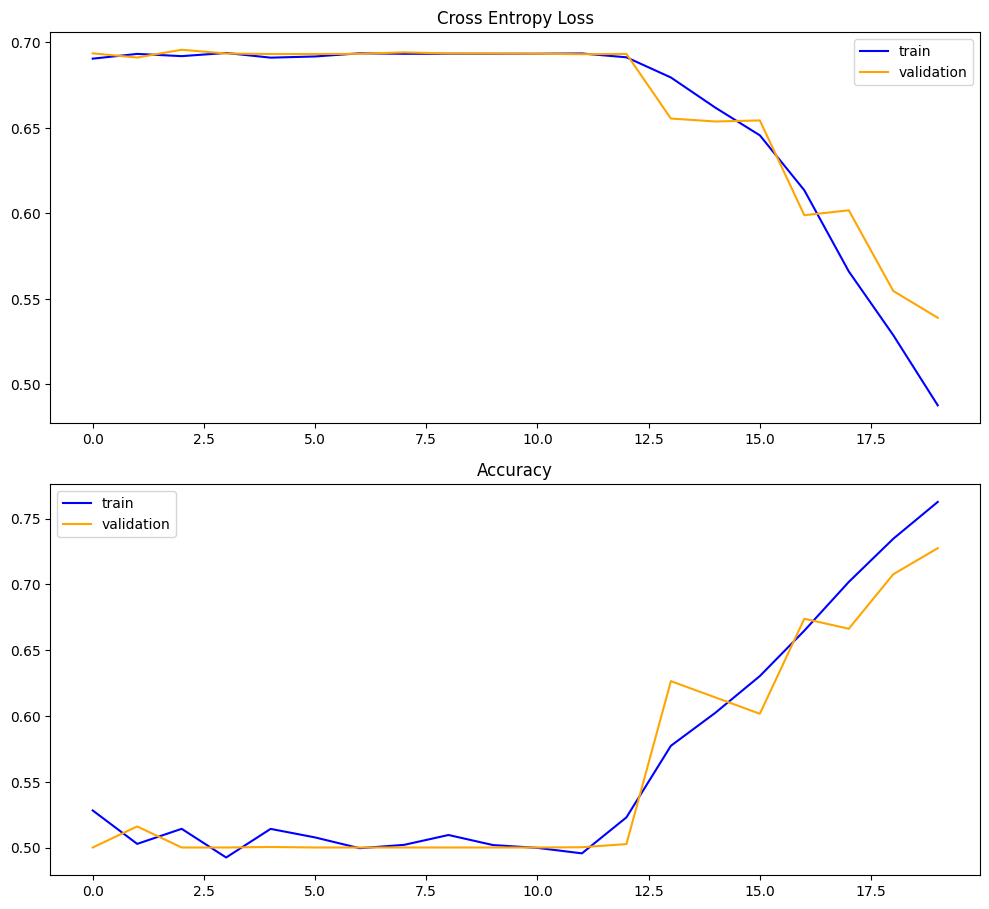

In [ ]:
H_dropout, history_dropout=run_test_harness()

In [ ]:
from tensorflow.keras.models import load_model
#salviamo il modello
H_dropout.save('cnn_droput_3.h5')

Try data augmentation

In [ ]:

dataset_path = '/content/images/PetImages/'
# Configurazione dell'augmentation delle immagini per il training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # Gradi di rotazione casuale
    width_shift_range=0.2,  # Range (come frazione della larghezza totale) entro il quale può avvenire lo shift orizzontale
    height_shift_range=0.2, # Range (come frazione dell'altezza totale) entro il quale può avvenire lo shift verticale
    shear_range=0.2,        # Shear Intensity (intensità di taglio)
    zoom_range=0.2,         # Range per il zoom casuale
    horizontal_flip=True,   # Abilita il flip orizzontale delle immagini
    fill_mode='nearest',    # La strategia usata per riempire i pixel nuovi che possono apparire dopo una rotazione o uno shift
    validation_split=0.2    # Percentuale di dati da utilizzare come set di validazione
)

# Generatore per il set di validazione (senza augmentation, solo rescale)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Carica il dataset di training con augmentation
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Carica il dataset di validazione (senza augmentation)
validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation')


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


Epoch 1/20
625/625 [==============================] - 462s 739ms/step - loss: 0.6877 - accuracy: 0.5394 - precision_4: 0.5478 - recall_4: 0.4518 - val_loss: 0.6835 - val_accuracy: 0.5466 - val_precision_4: 0.8629 - val_recall_4: 0.1108
Epoch 2/20
625/625 [==============================] - 461s 738ms/step - loss: 0.6869 - accuracy: 0.5405 - precision_4: 0.5444 - recall_4: 0.4969 - val_loss: 0.6680 - val_accuracy: 0.5772 - val_precision_4: 0.5649 - val_recall_4: 0.6727
Epoch 3/20
625/625 [==============================] - 462s 739ms/step - loss: 0.6845 - accuracy: 0.5505 - precision_4: 0.5521 - recall_4: 0.5344 - val_loss: 0.6856 - val_accuracy: 0.5854 - val_precision_4: 0.7124 - val_recall_4: 0.2865
Epoch 4/20
625/625 [==============================] - 461s 737ms/step - loss: 0.6817 - accuracy: 0.5567 - precision_4: 0.5634 - recall_4: 0.5040 - val_loss: 0.6795 - val_accuracy: 0.5550 - val_precision_4: 0.7670 - val_recall_4: 0.1581
Epoch 5/20
625/625 [==============================] - 46

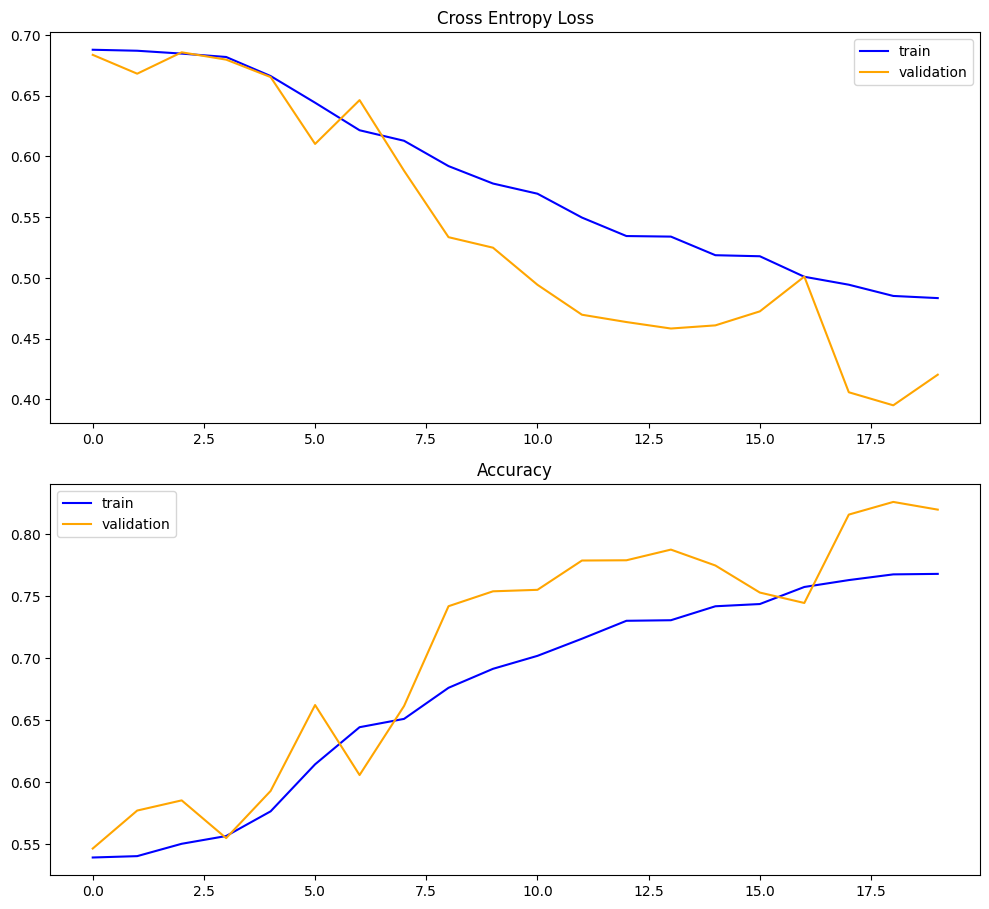

In [ ]:
H_data_augmented, history_data_augmented=run_test_harness()
H_data_augmented.save('cnn_droput_data_aug_2.h5')


Use a pretrained model

In [ ]:
import sys
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from livelossplot import PlotLossesKeras
from keras.models import Model
from keras.layers import Input

def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers[:15]:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.0001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model



c:\Users\shiev\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
587/625 [===========================>..] - ETA: 1:34 - loss: 0.4131 - accuracy: 0.8086 - precision: 0.8147 - recall: 0.7993

c:\Users\shiev\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 1837s 3s/step - loss: 0.4047 - accuracy: 0.8124 - precision: 0.8184 - recall: 0.8031 - val_loss: 0.1906 - val_accuracy: 0.9248 - val_precision: 0.9385 - val_recall: 0.9092
Epoch 2/20
625/625 [==============================] - 1821s 3s/step - loss: 0.2286 - accuracy: 0.9046 - precision: 0.9089 - recall: 0.8993 - val_loss: 0.1619 - val_accuracy: 0.9386 - val_precision: 0.9099 - val_recall: 0.9736
Epoch 3/20
625/625 [==============================] - 1810s 3s/step - loss: 0.1930 - accuracy: 0.9190 - precision: 0.9216 - recall: 0.9160 - val_loss: 0.1366 - val_accuracy: 0.9516 - val_precision: 0.9315 - val_recall: 0.9748
Epoch 4/20
625/625 [==============================] - 1843s 3s/step - loss: 0.1657 - accuracy: 0.9320 - precision: 0.9346 - recall: 0.9290 - val_loss: 0.1389 - val_accuracy: 0.9400 - val_precision: 0.9717 - val_recall: 0.9064
Epoch 5/20
625/625 [==============================] - 1849s 3s/step - loss: 0.1569 - accuracy: 0.9370 - pre

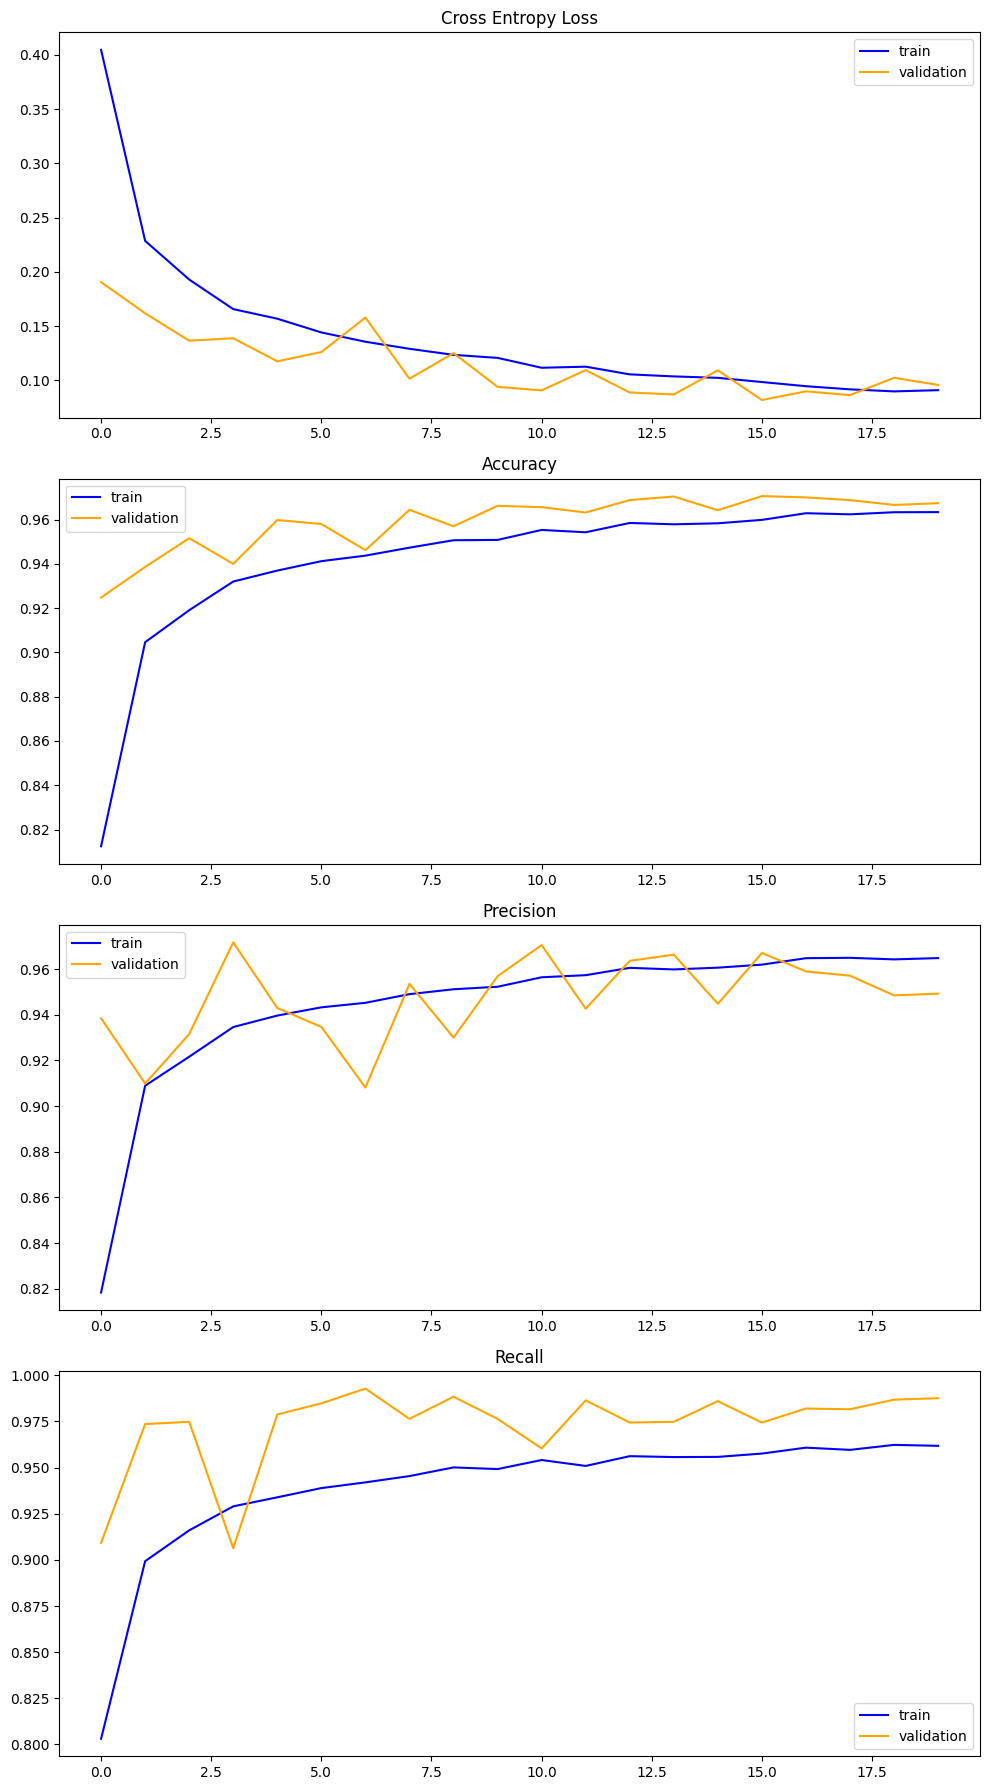

In [ ]:
H_vgg16, history_vgg16=run_test_harness()
H_vgg16.save('cnn_vgg16_1.h5')